In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import yaml
import random
import pandas as pd
import seaborn as sns
import cv2
import ibllib.io.video as vidio
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d
from scipy import stats
from daart.data import DataGenerator
from daart.transforms import ZScore
from daart.models import Segmenter
from one.api import ONE
from brainbox.io.one import SessionLoader
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from collections import Counter

# Connect to the IBL database
ONE.setup(base_url='https://openalyx.internationalbrainlab.org', silent=True)
one = ONE(password='international')

/home/nuttidalab/miniconda3/envs/iblenv/lib/python3.10/site-packages/one/params.py:184: UserWarning: Warning: the directory provided is already a cache for another URL.
  warnings.warn('Warning: the directory provided is already a cache for another URL.')


In [2]:
#@config
l_thresh = 0.0
view = 'left'
paw = 'paw_r'

In [3]:
#@static variables
eid_inferred = 'db4df448-e449-4a6f-a0e7-288711e7a75a'
preds = np.load("./stores/state_preds.npy") # (5, 208000)

state_labels = ['Still', 'Move', 'Wheel Turn', 'Groom']
state_keys = {1: 'Still', 2: 'Move', 3: 'Wheel Turn', 4: 'Groom'}
state_map = np.vectorize(lambda x: state_keys[x])

vid_url = vidio.url_from_eid(eid_inferred, one=one)[view]

In [4]:
# Function to extract and/or smooth ibl data
def extract_marker_data(eid, l_thresh, view, paw):
    #sess_id = dropbox_marker_paths[eid]

    # Load the pose data
    sl = SessionLoader(one=one, eid=eid)
    sl.load_pose(likelihood_thr=l_thresh, views=[view])
    times = sl.pose[f'{view}Camera'].times.to_numpy()
    markers = sl.pose[f'{view}Camera'].loc[:, (f'{paw}_x', f'{paw}_y')].to_numpy()

    # Load wheel data
    sl.load_wheel()
    wh_times = sl.wheel.times.to_numpy()
    wh_vel_oversampled = sl.wheel.velocity.to_numpy()
    
    # Resample wheel data at marker times
    interpolator = interp1d(wh_times, wh_vel_oversampled, fill_value='extrapolate')
    wh_vel = interpolator(times)

    # Process the data
    markers_comb = np.hstack([markers, wh_vel[:, None]])
    velocity = np.vstack([np.array([0, 0, 0]), np.diff(markers_comb, axis=0)])
    markers_comb = np.hstack([markers_comb, velocity])
    markers_z = (markers_comb - np.mean(markers_comb, axis=0)) / np.std(markers_comb, axis=0)
    feature_names = ['paw_x_pos', 'paw_y_pos', 'wheel_vel', 'paw_x_vel', 'paw_y_vel', 'wheel_acc']
    df = pd.DataFrame(markers_z, columns=feature_names)
    return df

In [5]:
marker_data = extract_marker_data(eid_inferred, l_thresh, view, paw)

In [6]:
data_df = marker_data.iloc[:208000, :].copy()

# Calculate the ensemble mode for each frame across the models
ensemble_mode = stats.mode(preds, axis=0).mode

# Calculate variance for each frame across the models
ensemble_variance = stats.variation(preds, axis=0)

# calculate the paw speed
data_df['paw_speed'] = np.sqrt(data_df['paw_x_vel']**2 + data_df['paw_y_vel']**2)

# calculate the wheel speed
data_df['wheel_speed'] = data_df['wheel_vel'].abs()

# Add the inferred states to the data
preds_labelled = state_map(preds)
for i in range(0, 5):
    data_df[f'mod_{i+1}'] = preds_labelled[i]

# add them all do the data frame
data_df['e_mode'] = state_map(ensemble_mode)
data_df['e_var'] = ensemble_variance
data_df['frame_id'] = np.arange(0, len(data_df))

# organize the columns:
cols = ['paw_x_pos', 'paw_y_pos', 'paw_x_vel', 'paw_y_vel', 'paw_speed',
        'wheel_vel', 'wheel_speed', 'wheel_acc',
        'mod_1', 'mod_2', 'mod_3', 'mod_4', 'mod_5', 'e_mode', 'e_var', 'frame_id']

# reorder the columns
data_df = data_df[cols]

data_df.round(2)

paw_x_pos  paw_y_pos  paw_x_vel  paw_y_vel  paw_speed  wheel_vel  \
0           -3.01      -8.00      -0.00      -0.00       0.00       0.04   
1           -2.97      -8.00       0.62      -0.00       0.62       0.04   
2           -2.94      -8.00       0.38      -0.00       0.38       0.04   
3           -2.94      -8.03      -0.00      -0.34       0.34       0.04   
4           -2.92      -8.03       0.26      -0.00       0.26       0.04   
...           ...        ...        ...        ...        ...        ...   
207995      -0.22      -0.80       0.00       0.00       0.00       0.04   
207996      -0.22      -0.80       0.01       0.01       0.01       0.04   
207997      -0.22      -0.80       0.01       0.01       0.01       0.04   
207998      -0.22      -0.80      -0.00      -0.00       0.00       0.04   
207999      -0.22      -0.80      -0.00      -0.00       0.00       0.04   

        wheel_speed  wheel_acc  mod_1  mod_2  mod_3  mod_4  mod_5 e_mode  \
0              0.04      -0.00  Groom  Groom  Groom  Groom  Groom  Groom   
1              0.04      -0.00  Groom  Groom  Groom  Groom  Groom  Groom   
2              0.04      -0.00  Groom  Groom  Groom  Groom  Groom  Groom   
3              0.04      -0.00  Groom  Groom  Groom  Groom  Groom  Groom   
4              0.04      -0.00  Groom  Groom  Groom  Groom  Groom  Groom   
...             ...        ...    ...    ...    ...    ...    ...    ...   
207995         0.04       0.02  Still  Still  Still  Still  Still  Still   
207996         0.04      -0.00  Still  Still  Still  Still  Still  Still   
207997         0.04      -0.01  Still  Still  Still  Still  Still  Still   
207998         0.04       0.01  Still  Still  Still  Still  Still  Still   
207999         0.04      -0.00  Still  Still  Still  Still  Still  Still   

        e_var  frame_id  
0         0.0         0  
1         0.0         1  
2         0.0         2  
3         0.0         3  
4         0.0         4  
...       ...       ...  
207995    0.0    207995  
207996    0.0    207996  
207997    0.0    207997  
207998    0.0    207998  
207999    0.0    207999  

[208000 rows x 16 columns]

## wheel speed conditoioned
wheel speed (not velocity) conditioned on still → wheel_turn, and a separate panel conditioned on wheel_turn → still

In [7]:
# Identify transition frames
model_to_use = 'e_mode'

still_to_wheel_turn_frames = data_df[
    (data_df[model_to_use].shift() == 'Still') & (data_df[model_to_use] == 'Wheel Turn')
].index

wheel_turn_to_still_frames = data_df[
    (data_df[model_to_use].shift() == 'Wheel Turn') & (data_df[model_to_use] == 'Still')
].index

still_to_move_frames = data_df[
    (data_df[model_to_use].shift() == 'Still') & (data_df[model_to_use] == 'Move')
].index

move_to_still_frames = data_df[
    (data_df[model_to_use].shift() == 'Move') & (data_df[model_to_use] == 'Still')
].index

In [8]:
# Extract transition data with -50 to +100 frames around transitions
def extract_transition_data_with_window(frames, data, data_col, pre_window=50, post_window=100):
    transition_data = []
    for frame in frames:
        if frame - pre_window >= 0 and frame + post_window < len(data):  # Ensure bounds
            transition_data.append(data.iloc[frame - pre_window:frame + post_window][data_col].values)
    return transition_data

# Average the data for smoother plot
def average_transition_data(transition_data):
    if transition_data:
        return pd.DataFrame(transition_data).mean(axis=0)
    return pd.Series()


In [9]:
still_to_wheel_turn_data = extract_transition_data_with_window(still_to_wheel_turn_frames, data_df, data_col="wheel_speed")
wheel_turn_to_still_data = extract_transition_data_with_window(wheel_turn_to_still_frames, data_df, data_col="wheel_speed")

still_to_wheel_turn_avg = average_transition_data(still_to_wheel_turn_data)
wheel_turn_to_still_avg = average_transition_data(wheel_turn_to_still_data)


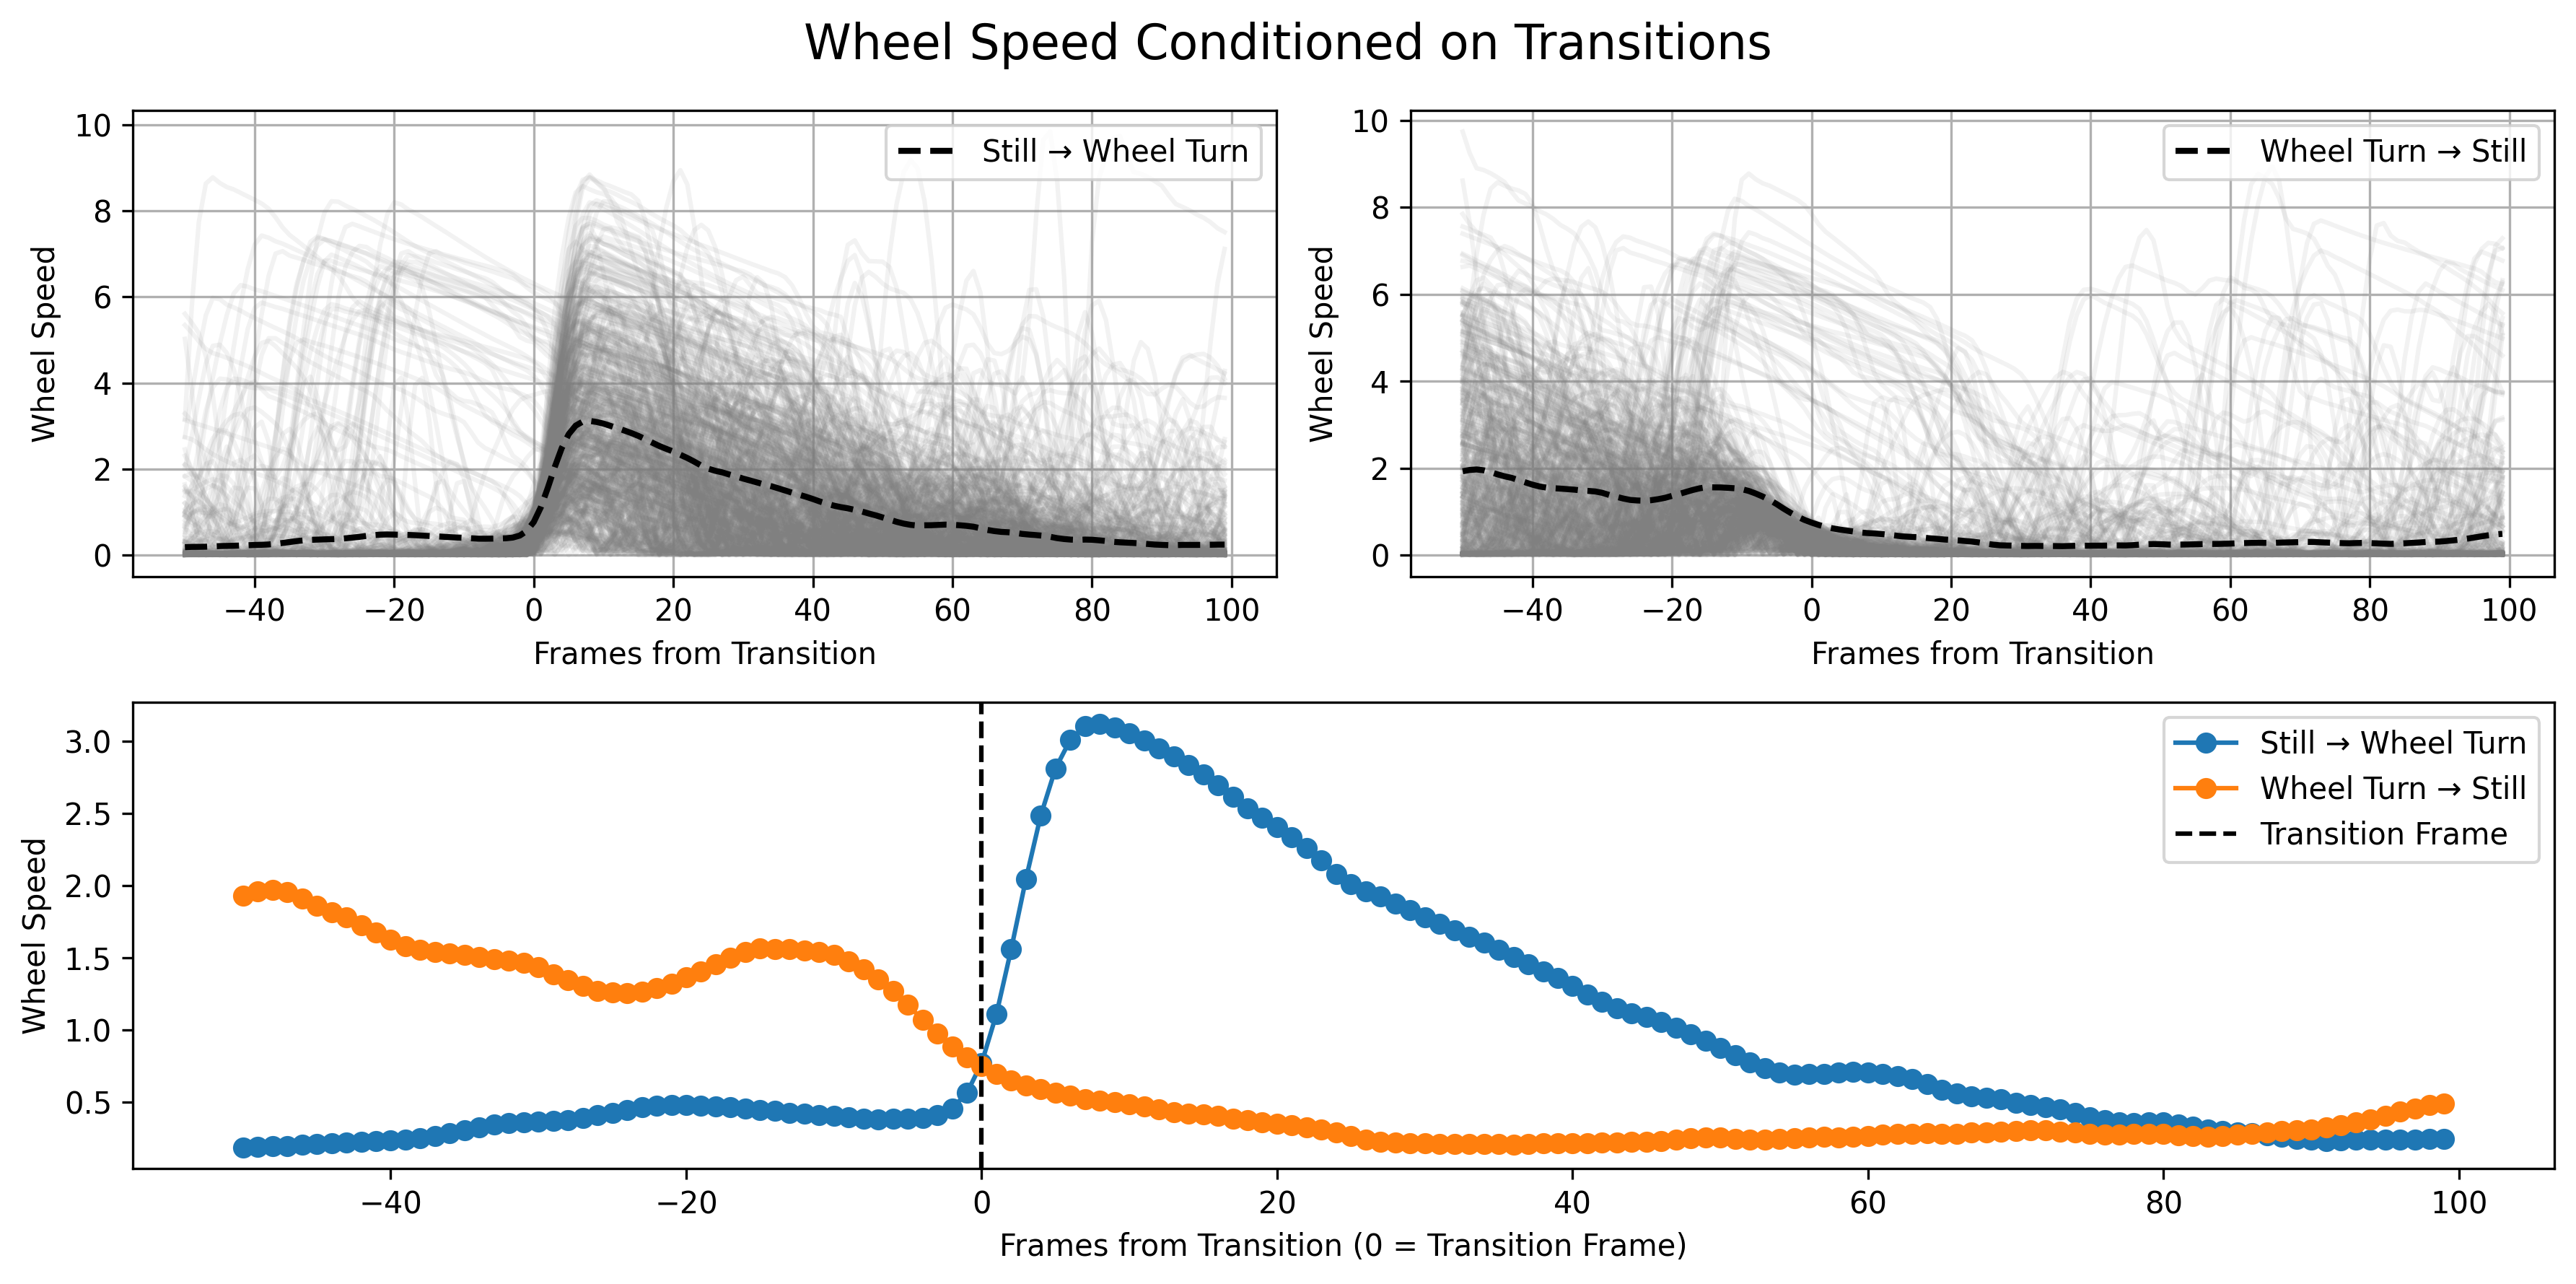

In [10]:
# Plot
fig = plt.figure(figsize=(12, 6), dpi=300)

# Create subplots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

x = np.arange(-50,100,1)  # 100 frames
alpha = 0.1

for line in still_to_wheel_turn_data:
    ax1.plot(x, line, color="gray", alpha=alpha)

if not still_to_wheel_turn_avg.empty:
    ax1.plot(x, still_to_wheel_turn_avg, "k--", label="Still → Wheel Turn", linewidth=2)

for line in wheel_turn_to_still_data:
    ax2.plot(x, line, color="gray", alpha=alpha)
    
if not wheel_turn_to_still_avg.empty:
    ax2.plot(x, wheel_turn_to_still_avg, "k--", label="Wheel Turn → Still", linewidth=2)

for a in [ax1, ax2]:
    # a.set_title("Wheel Speed Transitions")
    a.set_xlabel("Frames from Transition")
    a.set_ylabel("Wheel Speed")
    a.legend(loc='upper right')
    a.grid()

# Now the big boi

if not still_to_wheel_turn_avg.empty:
    ax3.plot(x, still_to_wheel_turn_avg, label="Still → Wheel Turn", marker="o")
if not wheel_turn_to_still_avg.empty:
    ax3.plot(x, wheel_turn_to_still_avg, label="Wheel Turn → Still", marker="o")

ax3.axvline(0, color='k', linestyle='--', label="Transition Frame")  # Highlight transition frame
# ax3.set_title("Wheel Speed Transitions (-50 to +100 Frames)")
ax3.set_xlabel("Frames from Transition (0 = Transition Frame)")
ax3.set_ylabel("Wheel Speed")
ax3.legend()
# ax3.grid()

plt.suptitle("Wheel Speed Conditioned on Transitions", fontsize=16)
plt.tight_layout()
plt.show()

## paw speed conditioned
```
still->wheel_turn
wheel_turn->still
still->move
move->still
```

In [11]:
still_to_wheel_turn_data = extract_transition_data_with_window(still_to_wheel_turn_frames, data_df, data_col="paw_speed")
wheel_turn_to_still_data = extract_transition_data_with_window(wheel_turn_to_still_frames, data_df, data_col="paw_speed")
still_to_move_data = extract_transition_data_with_window(still_to_move_frames, data_df, data_col="paw_speed")
move_to_still_data = extract_transition_data_with_window(move_to_still_frames, data_df, data_col="paw_speed")

still_to_wheel_turn_avg = average_transition_data(still_to_wheel_turn_data)
wheel_turn_to_still_avg = average_transition_data(wheel_turn_to_still_data)
still_to_move_avg = average_transition_data(still_to_move_data)
move_to_still_avg = average_transition_data(move_to_still_data)

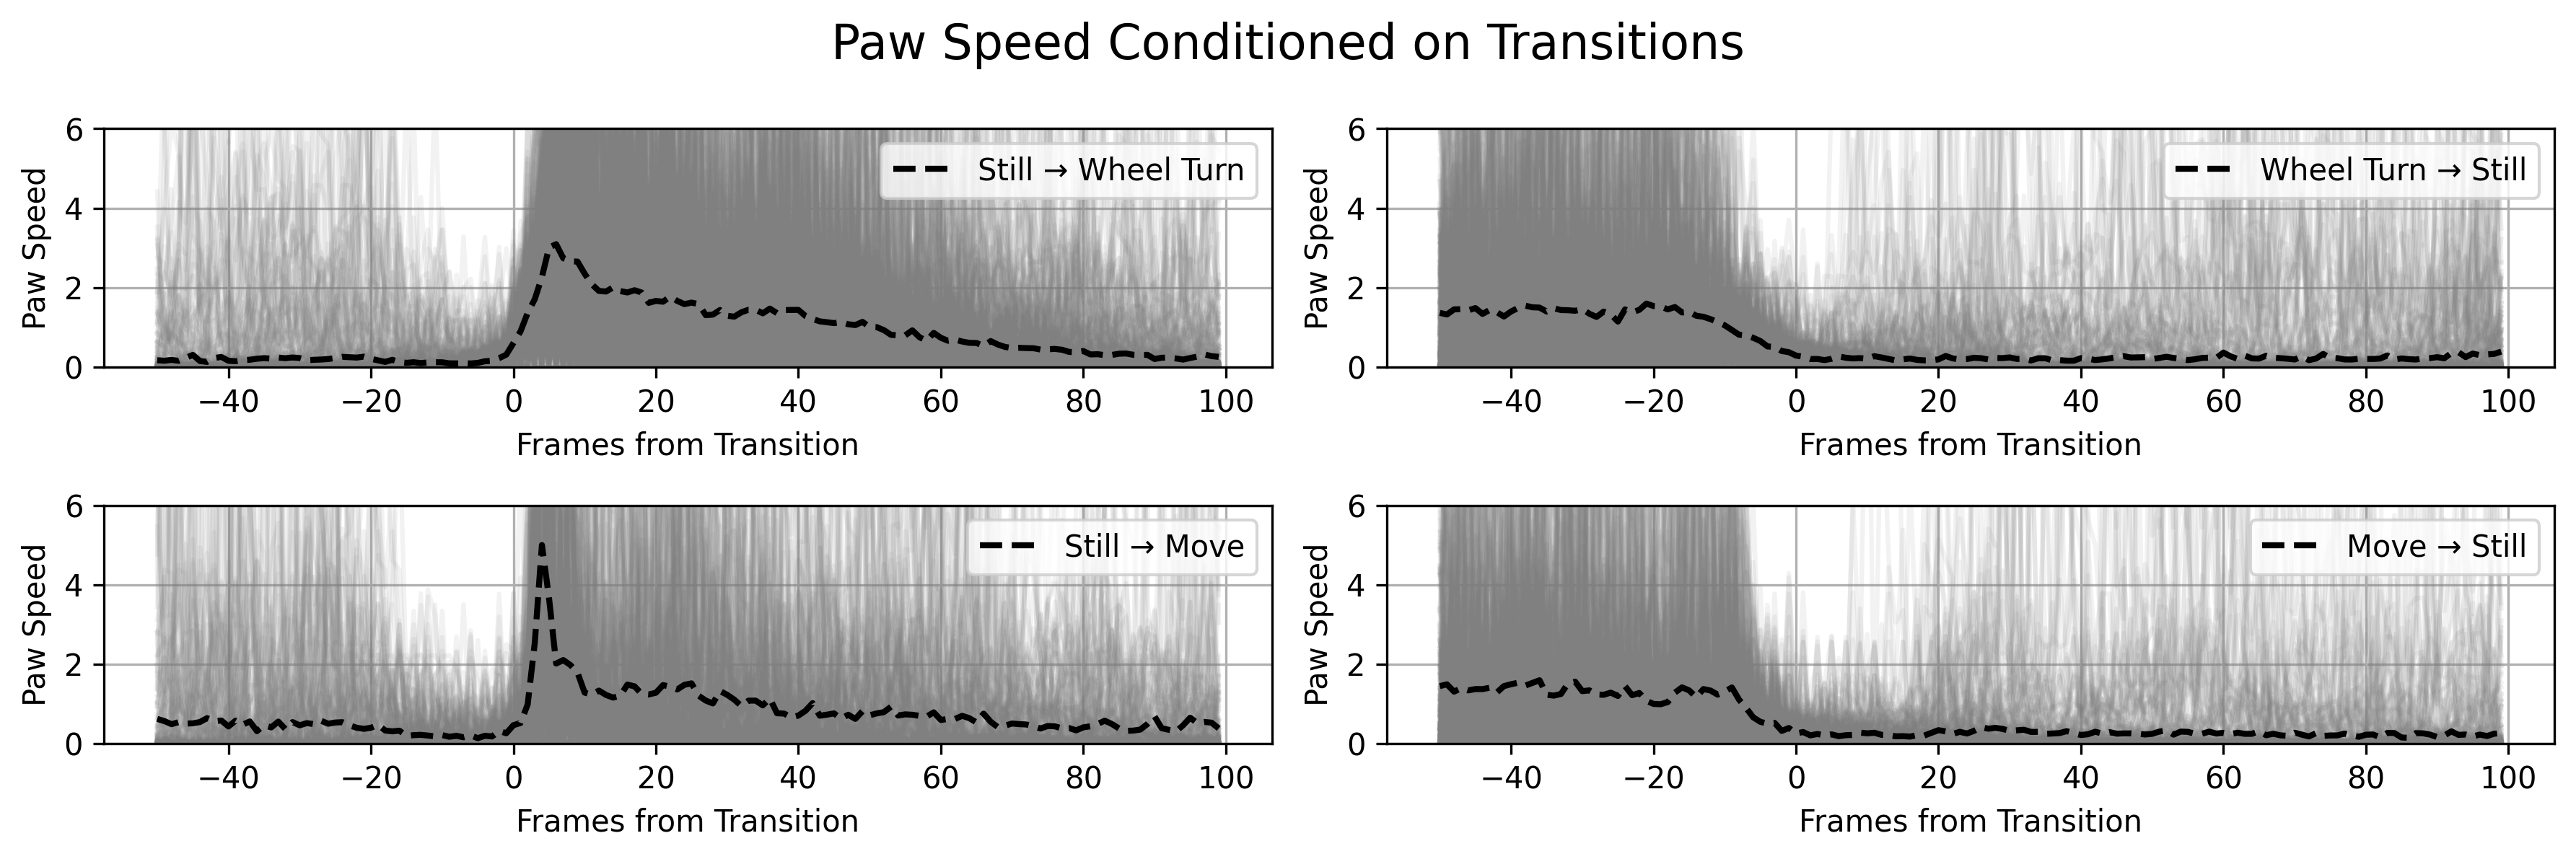

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 4), dpi=300)

x = np.arange(-50,100,1)  # 100 frames

alpha = 0.1

for line in still_to_wheel_turn_data:
    ax[0, 0].plot(x, line, color="gray", alpha=alpha)
ax[0, 0].plot(x, still_to_wheel_turn_avg, "k--", label="Still → Wheel Turn", linewidth=2)

for line in wheel_turn_to_still_data:
    ax[0, 1].plot(x, line, color="gray", alpha=alpha)
ax[0, 1].plot(x, wheel_turn_to_still_avg, "k--", label="Wheel Turn → Still", linewidth=2)

for line in still_to_move_data:
    ax[1, 0].plot(x, line, color="gray", alpha=alpha)
ax[1, 0].plot(x, still_to_move_avg, "k--", label="Still → Move", linewidth=2)

for line in move_to_still_data:
    ax[1, 1].plot(x, line, color="gray", alpha=alpha)
ax[1, 1].plot(x, move_to_still_avg, "k--", label="Move → Still", linewidth=2)

for a in ax.flatten():
    a.set_xlabel("Frames from Transition")
    a.set_ylabel("Paw Speed")
    a.set_ylim(0, 6)
    a.legend(loc='upper right')
    a.grid()

plt.suptitle("Paw Speed Conditioned on Transitions", fontsize=16)
plt.tight_layout()
plt.show()

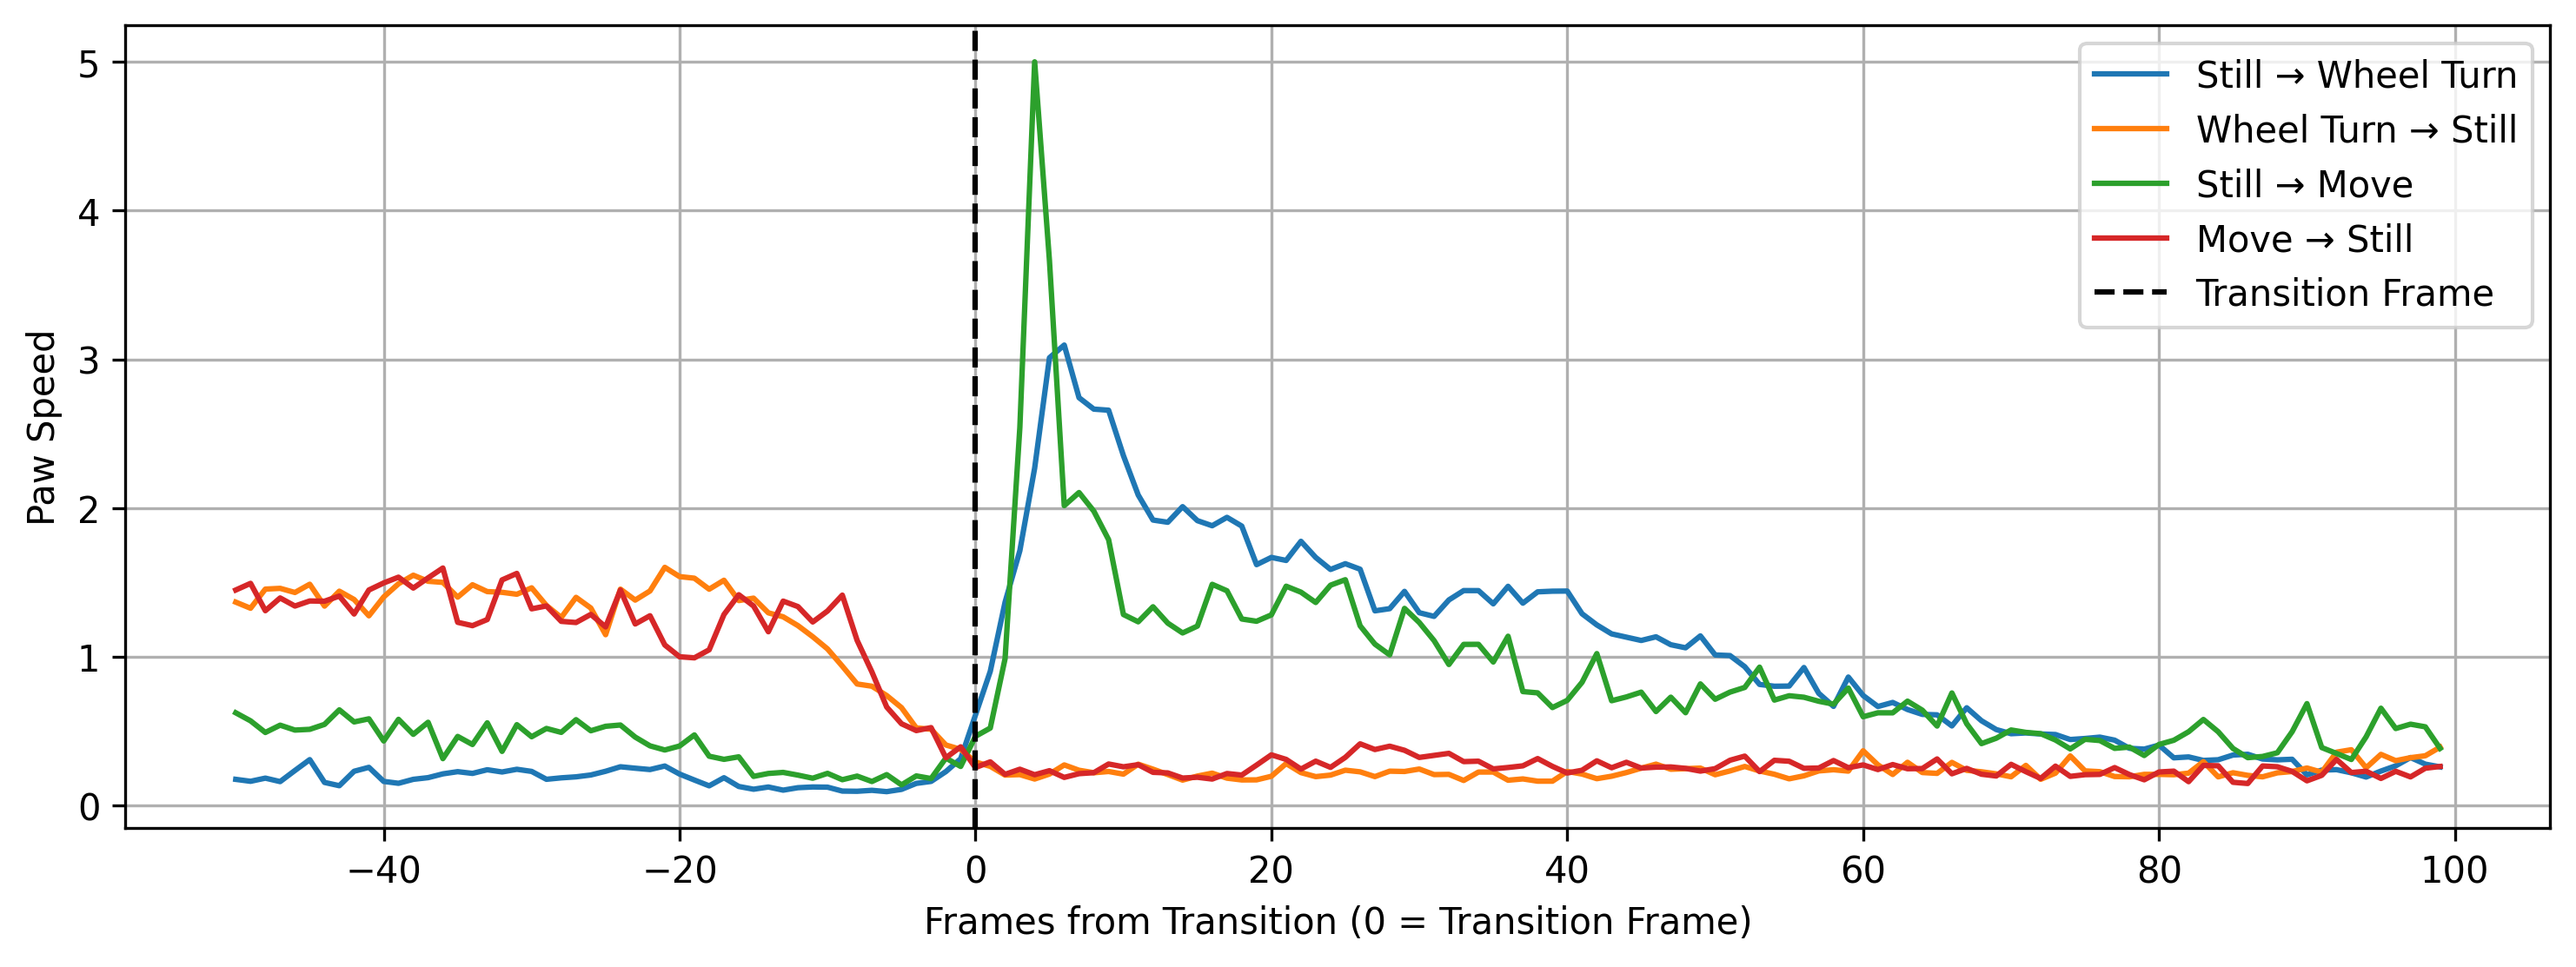

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12, 4), dpi=300)

x = np.arange(-50,100,1)

lines = [still_to_wheel_turn_avg, wheel_turn_to_still_avg, still_to_move_avg, move_to_still_avg]

for i, line_name in enumerate(["Still → Wheel Turn", "Wheel Turn → Still", "Still → Move", "Move → Still"]):
    ax.plot(x, lines[i], label=line_name)

ax.axvline(0, color='k', linestyle='--', label="Transition Frame")  # Highlight transition frame
ax.set_xlabel("Frames from Transition (0 = Transition Frame)")
ax.set_ylabel("Paw Speed")
ax.legend()
ax.grid()

## frames overlayed with markers

frames overlaid with markers - is there a way we can add more information here? like maybe the points can have an alpha value that corresponds to their speed, such that points when the paw is moving are more colorful, and points when the paw is still are more transparent. that way the "still" paw locations panel can tell us a bit more about whether or not the paw is actually moving there

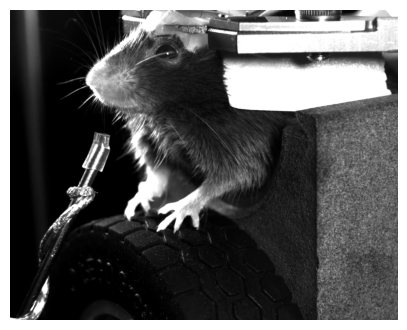

In [14]:
# read the video frames
cap = cv2.VideoCapture(vid_url)

# Reading the nth frame
for i in range(0, 1000):
    ret, frame = cap.read()

# plot the video frame
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(frame)
plt.axis('off')
plt.show()

In [26]:
frame_marker_df = data_df.copy()

sl = SessionLoader(one=one, eid=eid_inferred)
sl.load_pose(likelihood_thr=l_thresh, views=[view])
marker_px = sl.pose[f'{view}Camera'].loc[:, (f'{paw}_x', f'{paw}_y')].to_numpy()[:208000, :].T

frame_marker_df['paw_x_pos'] = marker_px[0]
frame_marker_df['paw_y_pos'] = marker_px[1]

scaler = RobustScaler()
frame_marker_df['paw_speed_normalized'] = scaler.fit_transform(data_df[['paw_speed']])
frame_marker_df['paw_speed_normalized'] = (frame_marker_df['paw_speed_normalized'] - frame_marker_df['paw_speed_normalized'].min()) / (frame_marker_df['paw_speed_normalized'].max() - frame_marker_df['paw_speed_normalized'].min())

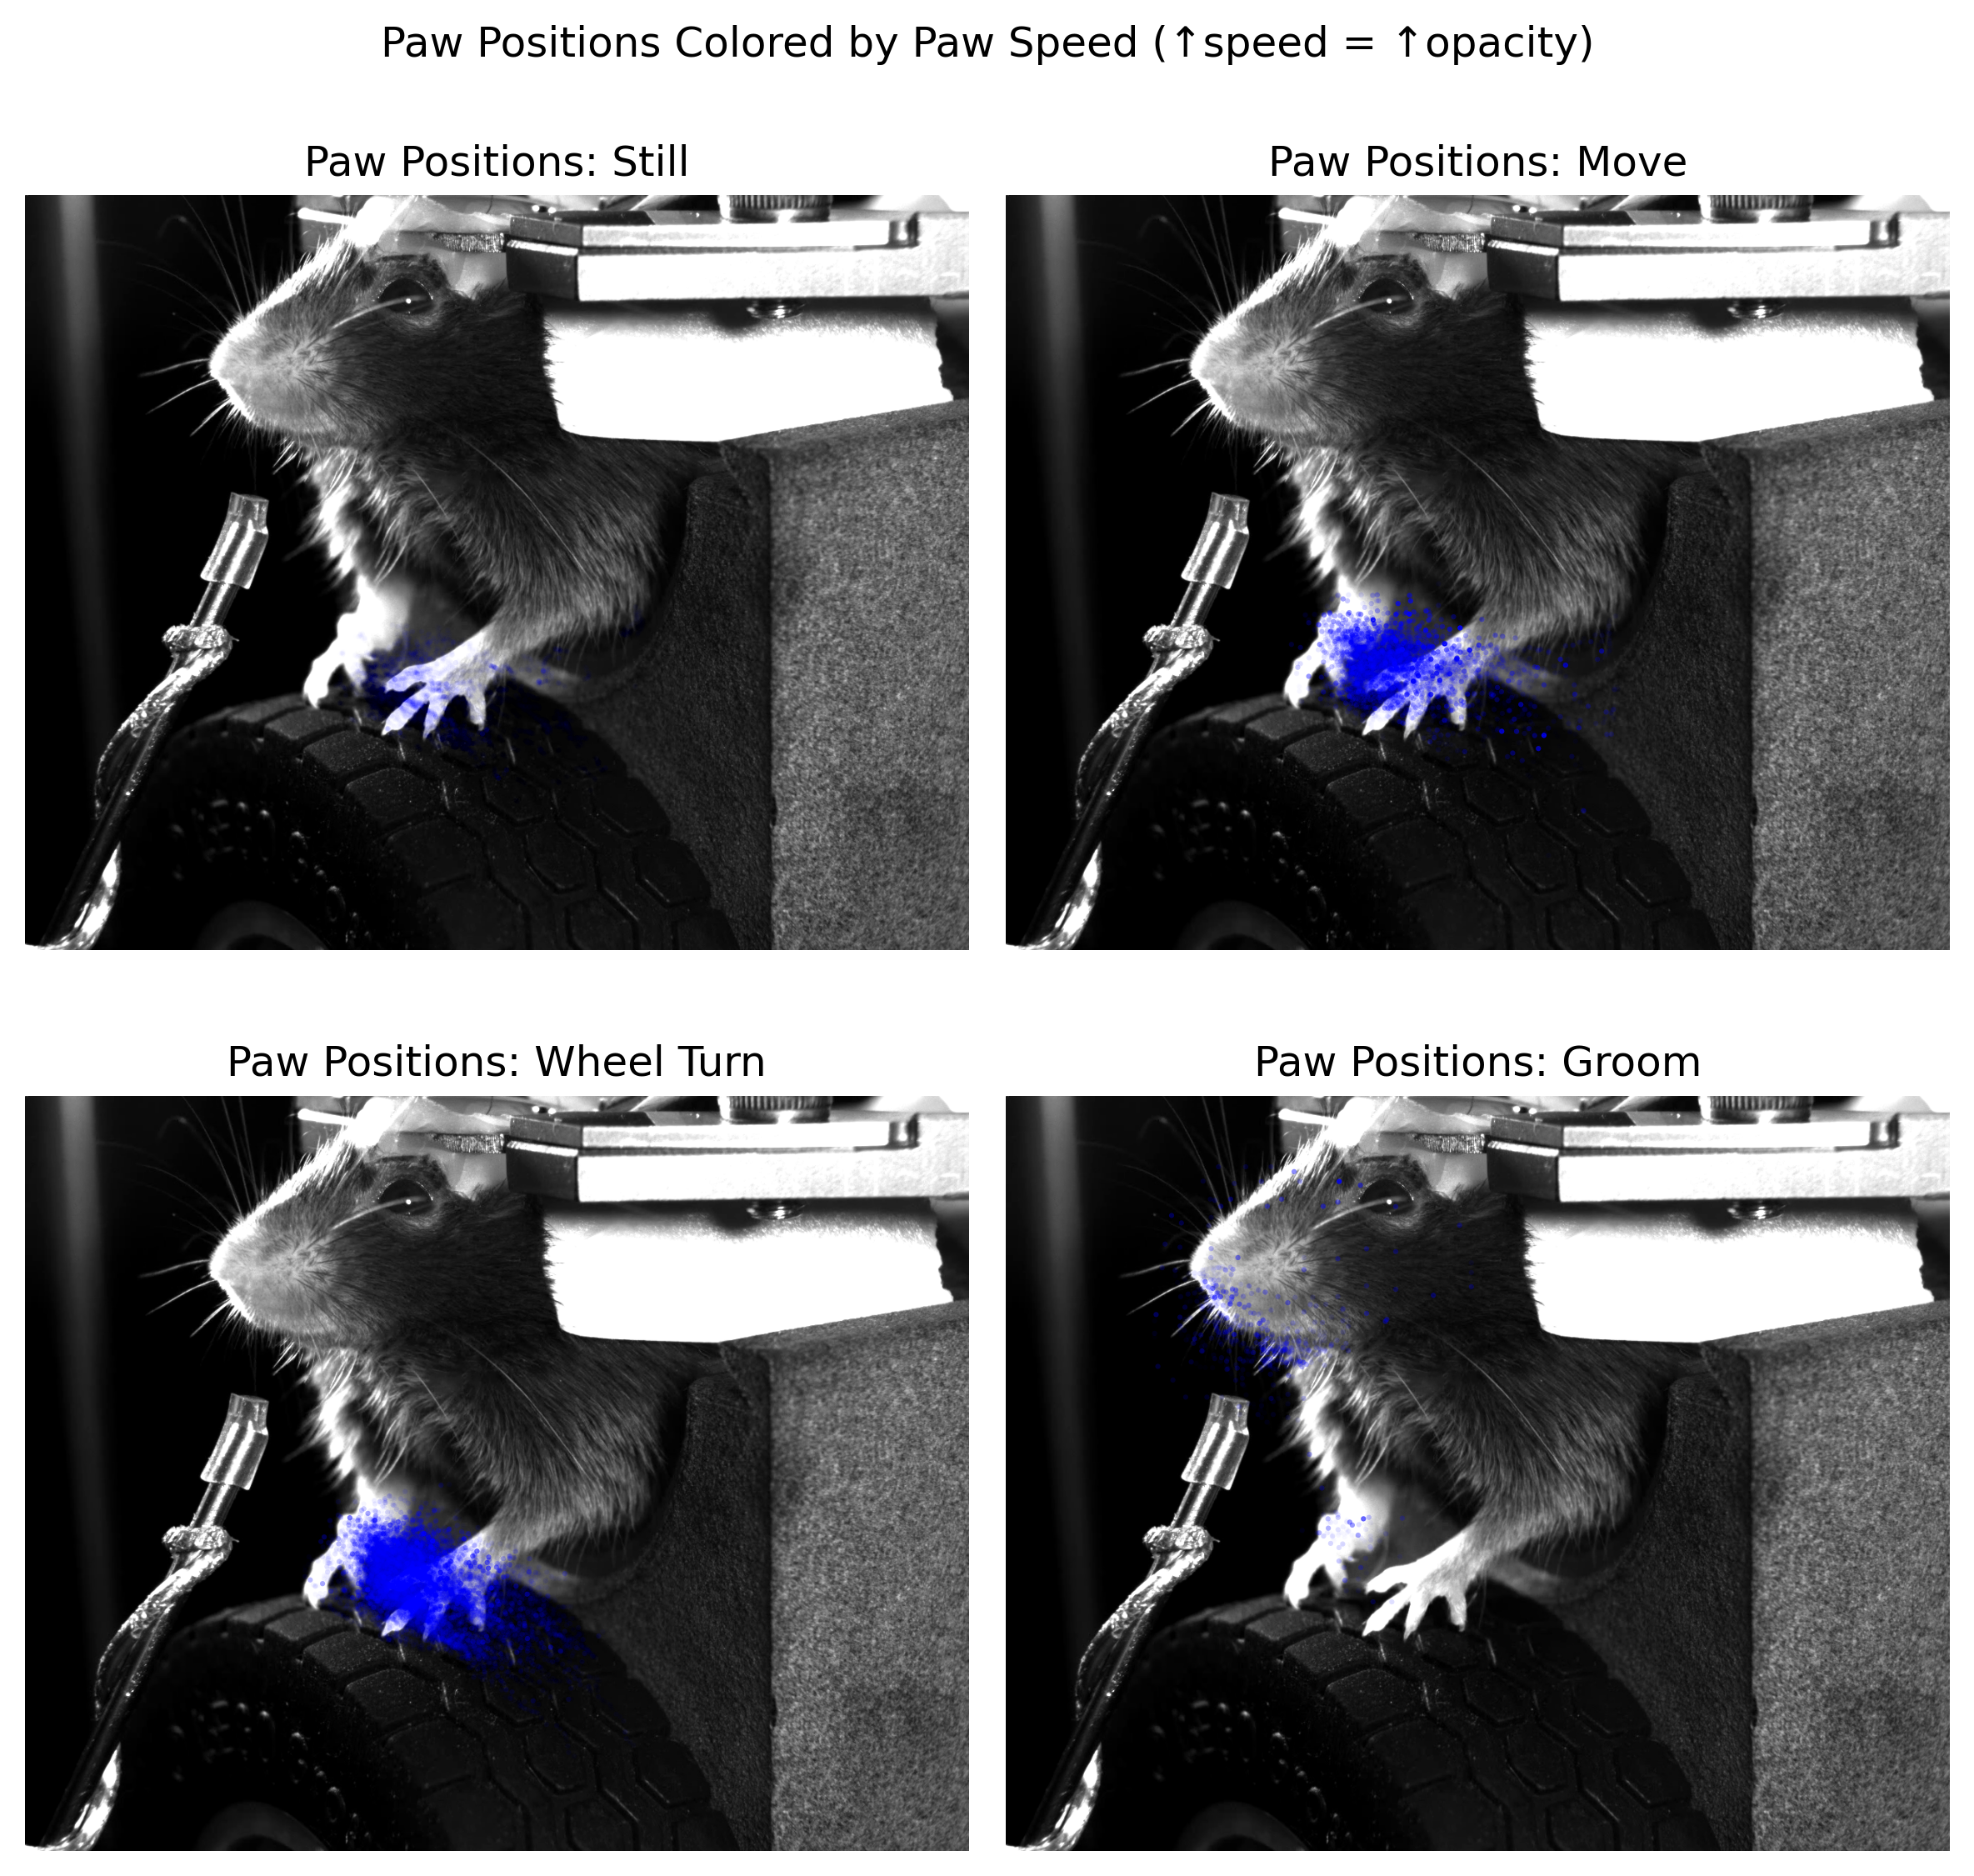

In [58]:
# Create a figure with a 1x4 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
states = state_labels # ['Still', 'Move', 'Wheel Turn', 'Groom']

for ax, state in zip(axs.flatten(), states):
    # Filter data for the current state
    state_data = frame_marker_df[frame_marker_df['e_mode'] == state]
    
    # Plot the base frame
    ax.imshow(frame)
    
    # Overlay points with alpha based on speed
    sc = ax.scatter(
        state_data['paw_x_pos'],
        state_data['paw_y_pos'],
        c='blue',
        alpha=state_data['paw_speed_normalized'],
        marker='.',
        s=1,  # Marker size
        label=f'{state} paw positions'
    )
    
    ax.set_title(f"Paw Positions: {state}")
    ax.axis('off')  # Hide axes for better visualization

# Add a colorbar
plt.suptitle("Paw Positions Colored by Paw Speed (↑speed = ↑opacity)", fontsize=12)

plt.tight_layout()
plt.show()

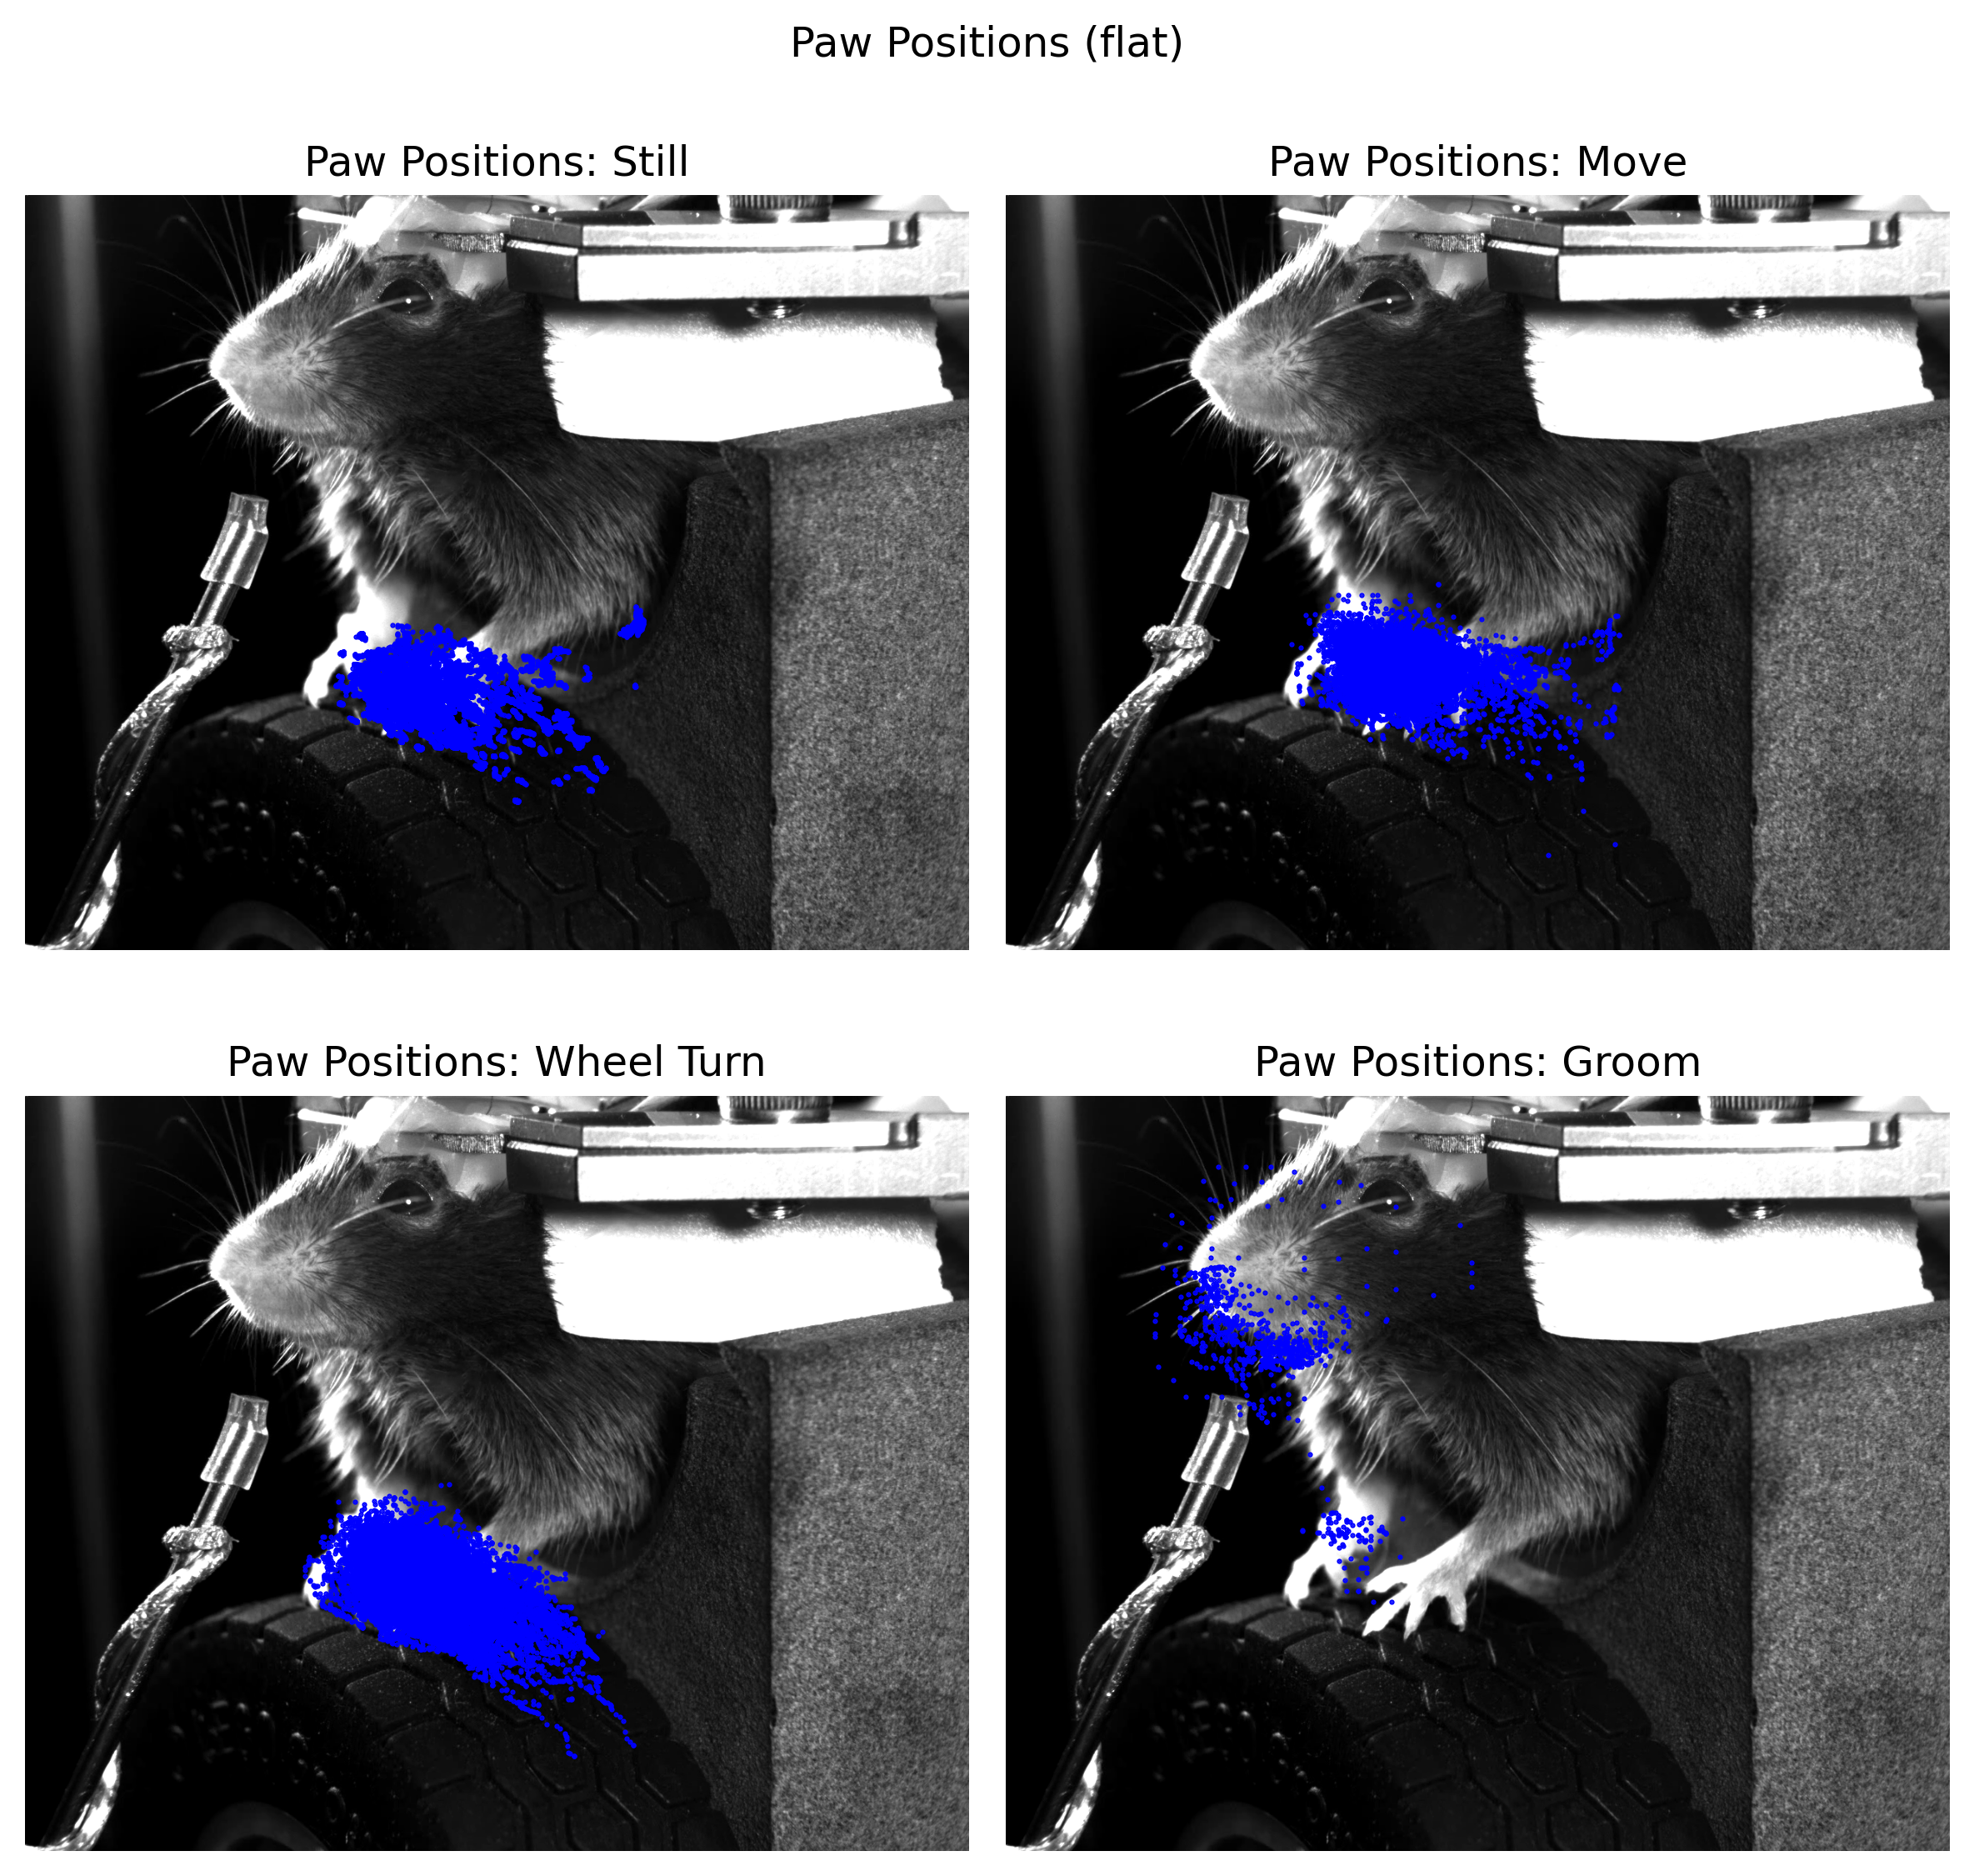

In [59]:
# Create a figure with a 1x4 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8), dpi=300)
states = state_labels # ['Still', 'Move', 'Wheel Turn', 'Groom']

for ax, state in zip(axs.flatten(), states):
    # Filter data for the current state
    state_data = frame_marker_df[frame_marker_df['e_mode'] == state]
    
    # Plot the base frame
    ax.imshow(frame)
    
    # Overlay points with alpha based on speed
    sc = ax.scatter(
        state_data['paw_x_pos'],
        state_data['paw_y_pos'],
        c='blue',
        # alpha=state_data['paw_speed_normalized'],
        marker='.',
        s=1,  # Marker size
        label=f'{state} paw positions'
    )
    
    ax.set_title(f"Paw Positions: {state}")
    ax.axis('off')  # Hide axes for better visualization

# Add a colorbar
plt.suptitle("Paw Positions (flat)", fontsize=12)

plt.tight_layout()
plt.show()